## Coloração de imagens

## Bibliotecas

In [1]:
import time
import warnings
import numpy as np
import random as rnd
from os import listdir
from skimage import color
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os.path import isfile, join
warnings.filterwarnings("ignore")
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.ticker import NullLocator, ScalarFormatter

## Carregando o Banco de Dados

In [2]:
path = 'DataBaseResize/'
files = [f for f in listdir(path) if isfile(join(path,f))]

images_db = []

for file in files:
    images_db.append(color.rgb2lab(color.rgba2rgb(mpimg.imread(join(path,file)))))
    
images_db = np.array(images_db)

## Plotando algumas imagens

In [3]:
SEED = 42

n_samples = 4

rnd.seed(SEED)

samples = rnd.sample(range(images_db.shape[0]), n_samples)

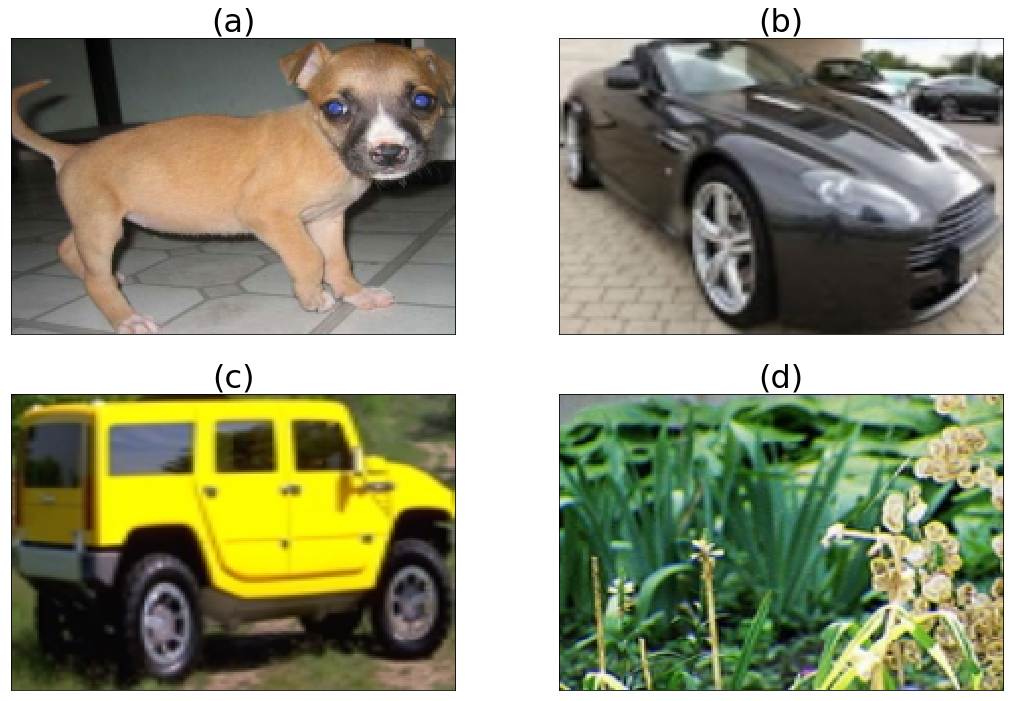

In [4]:
fig, axs = plt.subplots(2,2, figsize = (18,12))

titles = [['(a)', '(b)'], ['(c)', '(d)']]

count = 0

for axss, titless in zip(axs,titles):
    for ax, title in zip(axss, titless):
        
        # Plot Data
        
        ax.imshow(color.lab2rgb(images_db[samples[count]]))
        
        # Set title
        
        ax.set_title(title, fontsize = 32)
        
        # Remove axis
        
        ax.xaxis.set_major_locator(NullLocator())
        ax.yaxis.set_major_locator(NullLocator())
        
        # Count
        
        count += 1
        
plt.savefig('Out/samples.png', bbox_inches = 'tight');

## Isolando os canais L, a e b

In [5]:
images_db_L = images_db[:,:,:,0]
images_db_ab = images_db[:,:,:,1:]

## Plotando imagens dos canais L, a e b

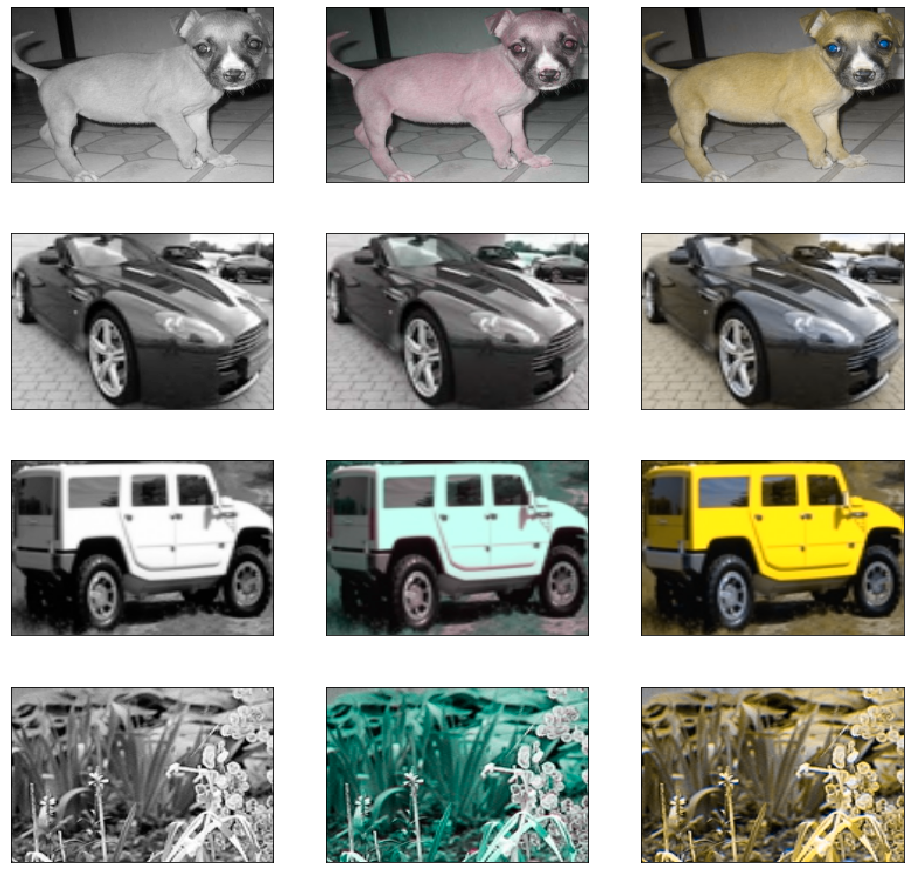

In [6]:
fig, axs = plt.subplots(4,3, figsize = (16,16))

count = 0

for ax, sample in zip(axs, samples):
        
    # Plot Data
        
    ax[0].imshow(images_db_L[sample], cmap = 'gray')
    
    image = np.zeros_like(images_db[sample])
    
    image[:,:,0] = images_db_L[sample]
    image[:,:,1] = images_db_ab[sample,:,:,0]
    
    ax[1].imshow(color.lab2rgb(image))
    
    image = np.zeros_like(images_db[sample])
    
    image[:,:,0] = images_db_L[sample]
    image[:,:,2] = images_db_ab[sample,:,:,1]
    
    ax[2].imshow(color.lab2rgb(image))
        
    # Remove axis
        
    ax[0].xaxis.set_major_locator(NullLocator())
    ax[0].yaxis.set_major_locator(NullLocator())
    ax[1].xaxis.set_major_locator(NullLocator())
    ax[1].yaxis.set_major_locator(NullLocator())
    ax[2].xaxis.set_major_locator(NullLocator())
    ax[2].yaxis.set_major_locator(NullLocator())
    
plt.savefig('Out/channels.png', bbox_inches = 'tight');

## Alterando a forma das matrizes

In [7]:
n, height, width, n_channels = images_db_ab.shape
images_db_ab = images_db_ab.reshape(n,height*width,n_channels)

In [8]:
n, height, width = images_db_L.shape
images_db_L = images_db_L.reshape(n,height*width)

## Separando as imagens em grupos de treinamento e teste

In [9]:
trainX, testX, trainY, testY = train_test_split(images_db_L, images_db_ab, test_size = 0.2, random_state = 42)

# CNN Regressão

## Treinando o modelo

In [10]:
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [11]:
model1 = MLPRegressor(
    hidden_layer_sizes = (512,256,128,64,32),
    max_iter = 500, 
    activation = 'tanh', 
    solver = 'adam', 
    random_state = 42)

In [12]:
tac = time.perf_counter() 
model1.fit(trainX_scaled, trainY[:,:,0])
tic = time.perf_counter()
print("Tempo de execução: ", np.round(tic-tac,2))

Tempo de execução:  950.49


In [13]:
y_pred = model1.predict(testX_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(testY[:,:,0],y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(testY[:,:,0],y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY[:,:,0],y_pred)))

Mean Absolute Error: 8.13524
Mean Squared Error: 169.55357
Root Mean Squared Error: 13.021274


In [14]:
model2 = MLPRegressor(
    hidden_layer_sizes = (512,256,128,64,32),
    max_iter = 500, 
    activation = 'tanh', 
    solver = 'adam', 
    random_state = 42)

In [15]:
tac = time.perf_counter() 
model2.fit(trainX_scaled, trainY[:,:,1])
tic = time.perf_counter()
print("Tempo de execução: ", np.round(tic-tac,2))

Tempo de execução:  1086.2


In [16]:
y_pred = model2.predict(testX_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(testY[:,:,1],y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(testY[:,:,1],y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY[:,:,1],y_pred)))

Mean Absolute Error: 11.471565
Mean Squared Error: 260.99884
Root Mean Squared Error: 16.155458


## Predisendo as imagens

In [17]:
samples = [563,1097,464,673,1269,598,975,596,501]

In [18]:
images_predict = []

for sample in samples:
    image_predict = np.zeros(images_db.shape[1:])
    image_predict[:,:,0] = testX[sample].reshape(image_predict.shape[:2])
    image_predict[:,:,1] = model1.predict(testX_scaled[sample].reshape((1,-1))).reshape(image_predict.shape[:2])
    image_predict[:,:,2] = model2.predict(testX_scaled[sample].reshape((1,-1))).reshape(image_predict.shape[:2])
    images_predict.append(image_predict)
    
images_predict = np.array(images_predict)

In [19]:
images_origin = []

for sample in samples:
    image_origin = np.zeros(images_db.shape[1:])
    image_origin[:,:,0] = testX[sample].reshape(image_origin.shape[:2])
    image_origin[:,:,1:] = testY[sample].reshape(
        image_origin.shape[0],
        image_origin.shape[1],
        testY[sample].shape[-1])
    images_origin.append(image_origin)
    
images_origin = np.array(images_origin)

## Plotando as imagens previstas

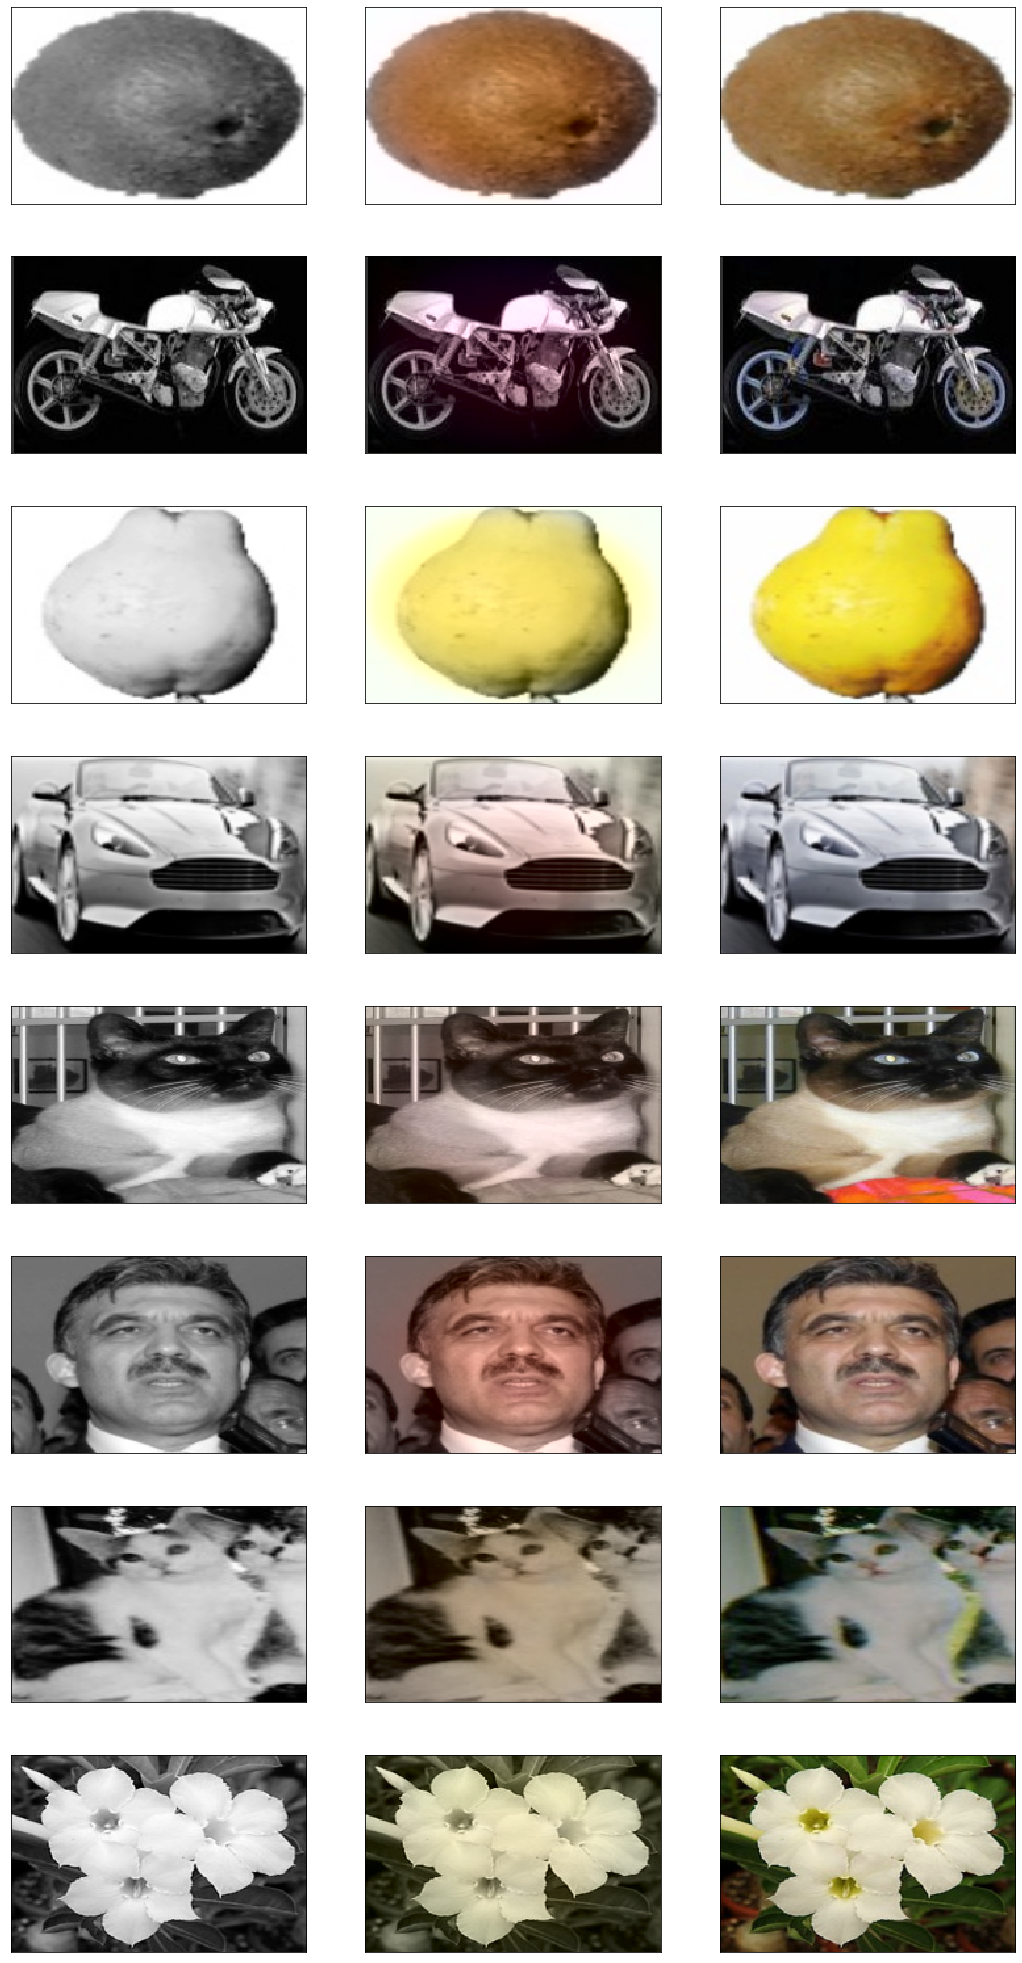

In [20]:
fig, axs = plt.subplots(8,3, figsize = (18,36))

count = 0

for ax, sample in zip(axs,samples):
        
    # Plot Data
        
    ax[0].imshow(testX[sample].reshape(images_predict[count].shape[:2]), cmap = 'gray')
    ax[1].imshow(color.lab2rgb(images_predict[count]))
    ax[2].imshow(color.lab2rgb(images_origin[count]))
        
    # Remove axis
        
    ax[0].xaxis.set_major_locator(NullLocator())
    ax[0].yaxis.set_major_locator(NullLocator())
    ax[1].xaxis.set_major_locator(NullLocator())
    ax[1].yaxis.set_major_locator(NullLocator())
    ax[2].xaxis.set_major_locator(NullLocator())
    ax[2].yaxis.set_major_locator(NullLocator())
        
    # Count
        
    count += 1
    
plt.savefig('Out/mosaico.png', bbox_inches = 'tight');